In [1]:
from io import StringIO

from pathlib import Path
import pandas
import numpy
import matplotlib.pyplot as plt

In [2]:
outdir = Path("./nomographs/volume")
outdir.mkdir(parents=True, exist_ok=True)
outdirqa = Path("./qa/volume")
outdirqa.mkdir(parents=True, exist_ok=True)

In [3]:
volume_paths = sorted((Path("./data/volume").glob("*.csv")))
volume_paths

[PosixPath('data/volume/1980s_Hist_Results.csv'),
 PosixPath('data/volume/2030s_Early_Results.csv'),
 PosixPath('data/volume/2050s_Mid_Results.csv'),
 PosixPath('data/volume/2080s_Late_Results.csv')]

In [4]:
def create_met_dataframe() -> pandas.DataFrame:
    string = """
epoch	mean_annual_precip_depth_inches	design_storm_precip_depth_inches	ro_coeff
1980s	35.539	0.652	0.450
2030s	35.982	0.715	0.468
2050s	40.338	0.759	0.495
2080s	38.060	0.800	0.505
"""

    df = pandas.read_table(StringIO(string))

    return df


met = (
    create_met_dataframe()
    .assign(area_acres=50)  # per jamie feldman and sarah welsh
    .assign(
        design_storm_volume_cuft=lambda df: (
            df["ro_coeff"]
            * df["area_acres"]
            * 43560  # acres to sqft
            * df["design_storm_precip_depth_inches"]
            / 12  # inches to ft
        )
    )
)

In [5]:
met

,epoch,mean_annual_precip_depth_inches,design_storm_precip_depth_inches,ro_coeff,area_acres,design_storm_volume_cuft
0,1980s,35.539,0.652,0.450,50,53252.1000
1,2030s,35.982,0.715,0.468,50,60733.5300
2,2050s,40.338,0.759,0.495,50,68190.4575
3,2080s,38.060,0.800,0.505,50,73326.0000


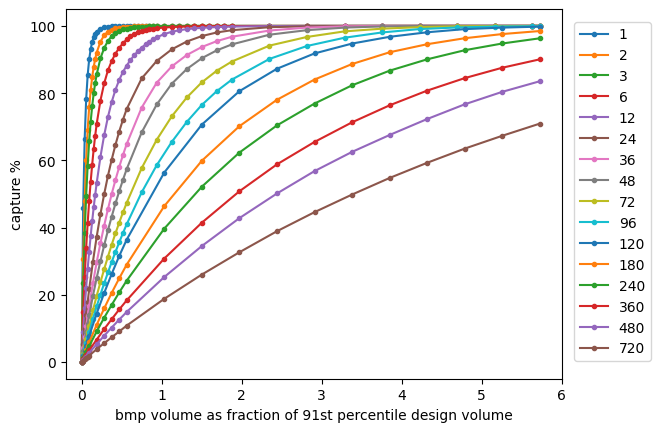

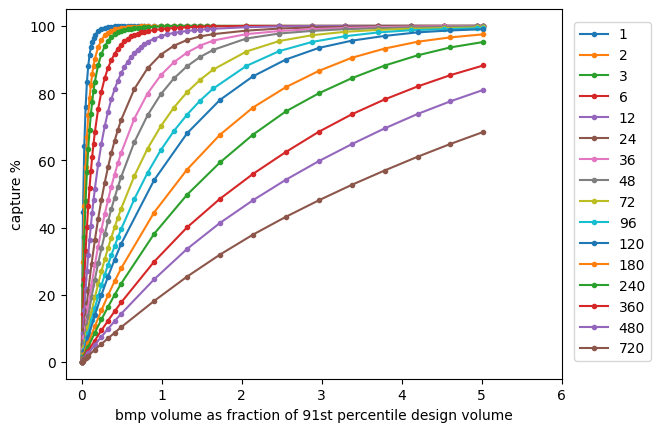

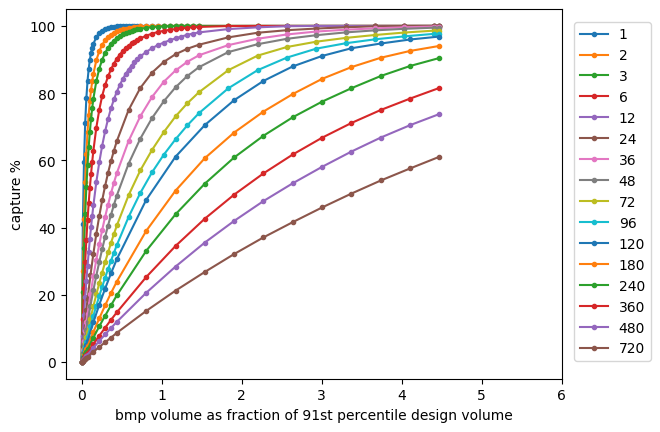

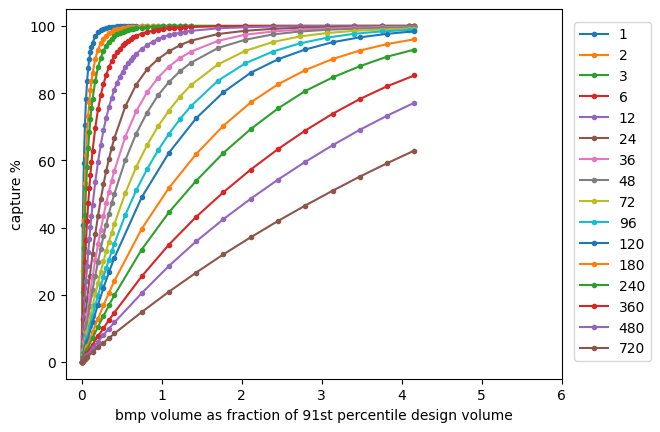

In [6]:
for f, (_, row) in zip(volume_paths, met.iterrows()):
    df = pandas.read_csv(f)
    epoch = f.stem.split("_")[0]
    assert epoch == row.epoch, (row, f, epoch)

    df["design_storm_volume_cuft"] = row.design_storm_volume_cuft
    df["vol_cuft"] = df["Vol_cf"]
    df["size_fraction"] = df["vol_cuft"] / df["design_storm_volume_cuft"]
    df["ddt_hr"] = df["DDT_hr"]
    df["capture_fraction"] = numpy.clip(df["Capture_Efficiency_%"] / 100, 0, 1.0)
    nulls = df["ddt_hr"].drop_duplicates().to_frame()
    nulls["size_fraction"] = 0
    nulls["capture_fraction"] = 0
    nulls["vol_cuft"] = 0.0

    df = pandas.concat([df, nulls], ignore_index=True)

    ls = []
    max_s = df.size_fraction.max()
    max_v = df.vol_cuft.max()
    for j, gp in df.groupby(["ddt_hr"], as_index=False):
        if gp.size_fraction.max() < max_s:
            dct = {"size_fraction": max_s, "ddt_hr": j[0], "vol_cuft": max_v}
            ls.append(dct)

    df = (
        pandas.concat([df, pandas.DataFrame(ls)])
        .sort_values(["ddt_hr", "size_fraction"])
        .fillna(method="ffill")
    )

    out = df.reindex(
        columns=["vol_cuft", "size_fraction", "ddt_hr", "capture_fraction"]
    ).round(4)
    out.to_csv(outdir / (row.epoch + ".csv"), index=False)

    df.to_csv(outdirqa / (row.epoch + ".csv"), index=False)

    fig, ax = plt.subplots()

    for i, df in out.groupby("ddt_hr"):
        ax.plot(
            df["size_fraction"], df["capture_fraction"] * 100, marker="o", ms=3, label=i
        )

    ax.set_xlim(-0.2, 6)
    ax.set_ylabel("capture %")
    ax.set_xlabel("bmp volume as fraction of 91st percentile design volume")

    fig.legend(loc="center right", bbox_to_anchor=(1.05, 0.5))

    fig.savefig(outdirqa / (row.epoch + ".png"), dpi=300, bbox_inches="tight")